UNIVERSIDADE ESTADUAL DO CEARÁ \
MESTRADO ACADÊMICO EM CIÊNCIA DA COMPUTAÇÃO \
MINERAÇÃO MASSIVA DE DADOS

Daniel Gleison Moreira Lira \
daniel.gleison@aluno.uece.br

---
# Mecanismo de predição de diagnóstico de diabetes utilizando aprendizado de máquina e processamento distribuído
---


## Dataset

http://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.# \
Date created: 2020-07-12

### Associated Tasks:
Classification

### Predicted attribute:
diabetes diagnostic

### Number of Instances:
520

### Number of Attributes:
17 (5 Decimal, 3 Integer, 3 String)

### Attribute Information:

Age 1.20-65 \
Sex 1. Male, 2.Female \
Polyuria 1.Yes, 2.No. \
Polydipsia 1.Yes, 2.No. \
sudden weight loss 1.Yes, 2.No. \
weakness 1.Yes, 2.No. \
Polyphagia 1.Yes, 2.No. \
Genital thrush 1.Yes, 2.No. \
visual blurring 1.Yes, 2.No. \
Itching 1.Yes, 2.No. \
Irritability 1.Yes, 2.No. \
delayed healing 1.Yes, 2.No. \
partial paresis 1.Yes, 2.No. \
muscle stiffness 1.Yes, 2.No. \
Alopecia 1.Yes, 2.No. \
Obesity 1.Yes, 2.No. \
Class 1.Positive, 2.Negative. 

### Missing Attribute Values: 
Yes

### Class Distribution: 
2 Classes \
320 Positive and 200 Negative

---

In [1]:
# Spark Lib
import findspark
findspark.init()

In [2]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col, regexp_replace
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer


from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import time
start_time = time.time()
%matplotlib inline

#Extras
##from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Criação do ambiente Spark

In [3]:
#Versão do Spark
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("PredictionDiabetes") \
        .getOrCreate()
spark

## Importação do dataset

In [4]:
data_path = './data/'
data_name = 'diabetes_data_upload.csv'
df_original = spark.read.format('csv')\
                   .options(sep=',', header='true',inferschema='true')\
                   .load(data_path+data_name)

In [5]:
print("Quantidade de linhas:",df_original.count())
print("Quantidade de colunas:",len(df_original.columns))

Quantidade de linhas: 520
Quantidade de colunas: 17


## Análise exploratória dos dados

In [6]:
df_original.createOrReplaceTempView("tab_original")
df_sql = spark.sql('select count(class) from tab_original where class = "Positive"')
df_sql.show()

+------------+
|count(class)|
+------------+
|         320|
+------------+



In [7]:
df_sql = spark.sql('select count(class) from tab_original where class = "Negative"')
df_sql.show()

+------------+
|count(class)|
+------------+
|         200|
+------------+



In [8]:
df_original.groupBy('class').count().show()

+--------+-----+
|   class|count|
+--------+-----+
|Positive|  320|
|Negative|  200|
+--------+-----+



In [9]:
df_original.select("*").toPandas()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [10]:
df_original.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,520,48.02884615384615,12.151465995249454,16,90
Gender,520,None,None,Female,Male
Polyuria,520,None,None,No,Yes
Polydipsia,520,None,None,No,Yes
sudden weight loss,520,None,None,No,Yes
weakness,520,None,None,No,Yes
Polyphagia,520,None,None,No,Yes
Genital thrush,520,None,None,No,Yes
visual blurring,520,None,None,No,Yes


In [11]:
df_original.show(vertical=True,truncate=False, n=1)

-RECORD 0----------------------
 Age                | 40       
 Gender             | Male     
 Polyuria           | No       
 Polydipsia         | Yes      
 sudden weight loss | No       
 weakness           | Yes      
 Polyphagia         | No       
 Genital thrush     | No       
 visual blurring    | No       
 Itching            | Yes      
 Irritability       | No       
 delayed healing    | Yes      
 partial paresis    | No       
 muscle stiffness   | Yes      
 Alopecia           | Yes      
 Obesity            | Yes      
 class              | Positive 
only showing top 1 row



In [12]:
from collections import defaultdict
data_types = defaultdict(list)
for entry in df_original.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)
data_types

defaultdict(list,
            {'IntegerType': ['Age'],
             'StringType': ['Gender',
              'Polyuria',
              'Polydipsia',
              'sudden weight loss',
              'weakness',
              'Polyphagia',
              'Genital thrush',
              'visual blurring',
              'Itching',
              'Irritability',
              'delayed healing',
              'partial paresis',
              'muscle stiffness',
              'Alopecia',
              'Obesity',
              'class']})

### Identificação de valores ausentes

In [13]:
df_original.select([count(when(isnull(c), c)).alias(c) for c in df_original.columns]).toPandas()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Matrix de correlação

In [14]:
df_original.toPandas().corr()

,Age
Age,1.0


## Transformação do dataset

### Indexação dos atributos de entrada

In [15]:
df_indexado = df_original

col = list(range(1, len(df_original.columns) - 1))

for x in col:

    indexer = StringIndexer(inputCol=df_original.columns[x], outputCol='index_'+df_original.columns[x]).fit(df_original)
    df_indexado = indexer.transform(df_indexado)
    labelReverse  = IndexToString().setInputCol(df_original.columns[x])
df_indexado.toPandas()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,...,index_Polyphagia,index_Genital thrush,index_visual blurring,index_Itching,index_Irritability,index_delayed healing,index_partial paresis,index_muscle stiffness,index_Alopecia,index_Obesity
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1,58,Male,No,No,No,Yes,No,No,Yes,No,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### Indexação da classe

In [16]:
df_indexado.select('class').toPandas()

,class
0,Positive
1,Positive
2,Positive
3,Positive
4,Positive
...,...
515,Positive
516,Positive
517,Positive
518,Negative


In [17]:
df_indexado = df_indexado.withColumn('class', regexp_replace('class', 'Positive', '1'))
df_indexado = df_indexado.withColumn('class', regexp_replace('class', 'Negative', '0'))
df_indexado = df_indexado.withColumn('class',df_indexado['class'].cast('Integer'))
df_indexado.select('class').toPandas()

,class
0,1
1,1
2,1
3,1
4,1
...,...
515,1
516,1
517,1
518,0


In [18]:
df_indexado = df_indexado.withColumnRenamed ('class', 'label')

In [19]:
df_indexado.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  320|
|    0|  200|
+-----+-----+



In [20]:
from collections import defaultdict
data_types = defaultdict(list)
for entry in df_indexado.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)
data_types

defaultdict(list,
            {'IntegerType': ['Age', 'label'],
             'StringType': ['Gender',
              'Polyuria',
              'Polydipsia',
              'sudden weight loss',
              'weakness',
              'Polyphagia',
              'Genital thrush',
              'visual blurring',
              'Itching',
              'Irritability',
              'delayed healing',
              'partial paresis',
              'muscle stiffness',
              'Alopecia',
              'Obesity'],
             'DoubleType': ['index_Gender',
              'index_Polyuria',
              'index_Polydipsia',
              'index_sudden weight loss',
              'index_weakness',
              'index_Polyphagia',
              'index_Genital thrush',
              'index_visual blurring',
              'index_Itching',
              'index_Irritability',
              'index_delayed healing',
              'index_partial paresis',
              'index_muscle stiffness',
  

### Exclusão de atributos

In [21]:
df_indexado.show(vertical=True,truncate=False, n=1)

-RECORD 0------------------------
 Age                      | 40   
 Gender                   | Male 
 Polyuria                 | No   
 Polydipsia               | Yes  
 sudden weight loss       | No   
 weakness                 | Yes  
 Polyphagia               | No   
 Genital thrush           | No   
 visual blurring          | No   
 Itching                  | Yes  
 Irritability             | No   
 delayed healing          | Yes  
 partial paresis          | No   
 muscle stiffness         | Yes  
 Alopecia                 | Yes  
 Obesity                  | Yes  
 label                    | 1    
 index_Gender             | 0.0  
 index_Polyuria           | 0.0  
 index_Polydipsia         | 1.0  
 index_sudden weight loss | 0.0  
 index_weakness           | 0.0  
 index_Polyphagia         | 0.0  
 index_Genital thrush     | 0.0  
 index_visual blurring    | 0.0  
 index_Itching            | 1.0  
 index_Irritability       | 0.0  
 index_delayed healing    | 1.0  
 index_partial

In [22]:
df_selecionado = df_indexado.drop('Gender',\
                                  'Polyuria',\
                                  'Polydipsia',\
                                  'sudden weight loss',\
                                  'weakness',\
                                  'Polyphagia',\
                                  'Genital thrush',\
                                  'visual blurring',\
                                  'Itching',\
                                  'Irritability',\
                                  'delayed healing',\
                                  'partial paresis',\
                                  'muscle stiffness',\
                                  'Alopecia',\
                                  'Obesity')\

df_selecionado.show(vertical=True,truncate=False, n=1)

-RECORD 0-----------------------
 Age                      | 40  
 label                    | 1   
 index_Gender             | 0.0 
 index_Polyuria           | 0.0 
 index_Polydipsia         | 1.0 
 index_sudden weight loss | 0.0 
 index_weakness           | 0.0 
 index_Polyphagia         | 0.0 
 index_Genital thrush     | 0.0 
 index_visual blurring    | 0.0 
 index_Itching            | 1.0 
 index_Irritability       | 0.0 
 index_delayed healing    | 1.0 
 index_partial paresis    | 0.0 
 index_muscle stiffness   | 1.0 
 index_Alopecia           | 1.0 
 index_Obesity            | 1.0 
only showing top 1 row



In [23]:
from collections import defaultdict
data_types = defaultdict(list)
for entry in df_selecionado.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)
data_types

defaultdict(list,
            {'IntegerType': ['Age', 'label'],
             'DoubleType': ['index_Gender',
              'index_Polyuria',
              'index_Polydipsia',
              'index_sudden weight loss',
              'index_weakness',
              'index_Polyphagia',
              'index_Genital thrush',
              'index_visual blurring',
              'index_Itching',
              'index_Irritability',
              'index_delayed healing',
              'index_partial paresis',
              'index_muscle stiffness',
              'index_Alopecia',
              'index_Obesity']})

In [24]:
df = df_selecionado.filter(df_selecionado['label'] == 1).sort(df_selecionado['label'])
df.toPandas()

,Age,label,index_Gender,index_Polyuria,index_Polydipsia,index_sudden weight loss,index_weakness,index_Polyphagia,index_Genital thrush,index_visual blurring,index_Itching,index_Irritability,index_delayed healing,index_partial paresis,index_muscle stiffness,index_Alopecia,index_Obesity
0,40,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1,58,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,41,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,45,1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60,1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,62,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
316,54,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
317,39,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
318,48,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


## Seleção dos atributos

In [25]:
df_selecionado.toPandas()

,Age,label,index_Gender,index_Polyuria,index_Polydipsia,index_sudden weight loss,index_weakness,index_Polyphagia,index_Genital thrush,index_visual blurring,index_Itching,index_Irritability,index_delayed healing,index_partial paresis,index_muscle stiffness,index_Alopecia,index_Obesity
0,40,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1,58,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,41,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,45,1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60,1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
516,48,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
517,58,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
518,32,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Criação da matrix de classificação

In [26]:
ignore = ['label']
list = [x for x in df_selecionado.columns if x not in ignore]

assembler = VectorAssembler(
            inputCols= list,
            outputCol='features')

df_transformado = (assembler.transform(df_selecionado).select('label','features'))
df_transformado.show(truncate = False, n = 5)
df_transformado.count()

+-----+------------------------------------------------------------------+
|label|features                                                          |
+-----+------------------------------------------------------------------+
|1    |(16,[0,3,9,11,13,14,15],[40.0,1.0,1.0,1.0,1.0,1.0,1.0])           |
|1    |(16,[0,8,12,14],[58.0,1.0,1.0,1.0])                               |
|1    |(16,[0,2,6,9,11,13,14],[41.0,1.0,1.0,1.0,1.0,1.0,1.0])            |
|1    |(16,[0,4,6,7,9,11],[45.0,1.0,1.0,1.0,1.0,1.0])                    |
|1    |[60.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]|
+-----+------------------------------------------------------------------+
only showing top 5 rows



520

## Divisão do dataset para treinamento e teste

In [27]:
train_sample = 0.7
test_sample = 0.3
seed = 1234

(train, test) = df_transformado.randomSplit([train_sample, test_sample],seed)

num_train = df_transformado.count() * train_sample
num_test = df_transformado.count() * test_sample

print('Percentual da base de treinamento', train_sample*100, '%')
print('Percentual da base de teste', test_sample*100, '%')
print('Quantidade de registros da base de treinamento:', train.count())
print('Quantidade de registros da base de treinamento:', test.count())

Percentual da base de treinamento 70.0 %
Percentual da base de teste 30.0 %
Quantidade de registros da base de treinamento: 356
Quantidade de registros da base de treinamento: 164


In [28]:
train.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  225|
|    0|  131|
+-----+-----+



In [29]:
test.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   95|
|    0|   69|
+-----+-----+



In [30]:
test.show(truncate = False)

+-----+------------------------------------------------------------+
|label|features                                                    |
+-----+------------------------------------------------------------+
|0    |(16,[0],[29.0])                                             |
|0    |(16,[0],[30.0])                                             |
|0    |(16,[0,1,4,5],[34.0,1.0,1.0,1.0])                           |
|0    |(16,[0,1,9,11,14],[65.0,1.0,1.0,1.0,1.0])                   |
|0    |(16,[0,2,4,7,9,11,14,15],[44.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0    |(16,[0,2,4,7,9,11,14,15],[44.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0    |(16,[0,2,4,7,9,11,14,15],[44.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0    |(16,[0,3,4,8,9,12,13],[40.0,1.0,1.0,1.0,1.0,1.0,1.0])       |
|0    |(16,[0,3,4,8,9,12,13],[40.0,1.0,1.0,1.0,1.0,1.0,1.0])       |
|0    |(16,[0,3,5,8,9,13],[58.0,1.0,1.0,1.0,1.0,1.0])              |
|0    |(16,[0,3,5,8,9,13],[58.0,1.0,1.0,1.0,1.0,1.0])              |
|0    |(16,[0,4,5],[28.0,1.0,1.0])

## Treinamento, teste e avaliação dos modelos de predição

### Decision Tree (DT)

In [31]:
# Treinamento do modelo de predição
start_time = time.time()
trainer_dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)
model_dt = trainer_dt.fit(train)
time_dt_train = time.time() - start_time

In [32]:
# Execução do modelo de predição na base de teste
start_time = time.time()
result_dt = model_dt.transform(test)
time_dt_pred = time.time() - start_time

In [33]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_dt = evaluator.evaluate(result_dt) * 100

In [34]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_dt = evaluator.evaluate(result_dt) * 100

In [35]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_dt = evaluator.evaluate(result_dt) * 100

In [36]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_dt = evaluator.evaluate(result_dt) * 100

In [37]:
# Matriz de confusão
y_true = result_dt.select("label").toPandas()
y_pred = result_dt.select("prediction").toPandas()
mc_dt = confusion_matrix(y_true, y_pred, labels = [0,1])
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_true, y_pred).ravel()
print(mc_dt)

[[68  1]
 [ 8 87]]


<AxesSubplot:>

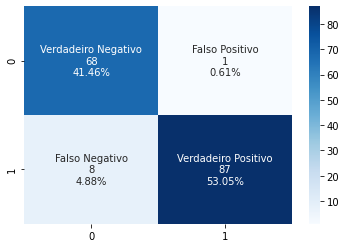

In [38]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_dt.flatten()/np.sum(mc_dt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_dt, annot=labels, fmt='', cmap='Blues')

In [39]:
# Exibição dos resultados
evaluator_dt = spark.createDataFrame(
    [(round(accuracy_dt,2), round(recall_dt,2), round(precision_dt,2), round(f1_dt,2),\
      int(fp_dt), int(fn_dt),\
      round(time_dt_train,2), round(time_dt_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Decision Tree:")
evaluator_dt.show()

Resultados do modelo Decision Tree:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   94.51| 94.51|   94.91|   94.54|             1|             8|             2.57|          0.06|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [40]:
result_dt.toPandas()

,label,features,rawPrediction,probability,prediction
0,0,"(29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[96.0, 4.0]","[0.96, 0.04]",0.0
1,0,"(30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[96.0, 4.0]","[0.96, 0.04]",0.0
2,0,"(34.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[4.0, 0.0]","[1.0, 0.0]",0.0
3,0,"(65.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.0, 0.0]","[1.0, 0.0]",0.0
4,0,"(44.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[1.0, 0.0]","[1.0, 0.0]",0.0
...,...,...,...,...,...
159,1,"[69.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0,...","[0.0, 4.0]","[0.0, 1.0]",1.0
160,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 17.0]","[0.0, 1.0]",1.0
161,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 17.0]","[0.0, 1.0]",1.0
162,1,"[70.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0,...","[0.0, 4.0]","[0.0, 1.0]",1.0


In [41]:
result_dt.createOrReplaceTempView("tab_result_dt")
dt_sql = spark.sql('select * from tab_result_dt where label != Prediction')
dt_sql.toPandas()

,label,features,rawPrediction,probability,prediction
0,0,"[65.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...","[0.0, 7.0]","[0.0, 1.0]",1.0
1,1,"(79.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0,...","[1.0, 1.0]","[0.5, 0.5]",0.0
2,1,"(58.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0,...","[1.0, 1.0]","[0.5, 0.5]",0.0
3,1,"(40.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[3.0, 0.0]","[1.0, 0.0]",0.0
4,1,"(57.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0,...","[3.0, 0.0]","[1.0, 0.0]",0.0
5,1,"(40.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3.0, 0.0]","[1.0, 0.0]",0.0
6,1,"(42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[7.0, 1.0]","[0.875, 0.125]",0.0
7,1,"(37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[96.0, 4.0]","[0.96, 0.04]",0.0
8,1,"(37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[96.0, 4.0]","[0.96, 0.04]",0.0


### Random Forest (RF)

In [42]:
# Treinamento do modelo de predição
start_time = time.time()
trainer = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 numTrees=50, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')
model_rf = trainer.fit(train)
time_rf_train = time.time() - start_time

In [43]:
# Execução do modelo de predição na base de teste
start_time = time.time()
result_rf = model_rf.transform(test)
time_rf_pred = time.time() - start_time

In [44]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_rf = evaluator.evaluate(result_rf) * 100

In [45]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_rf = evaluator.evaluate(result_rf) * 100

In [46]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_rf = evaluator.evaluate(result_rf) * 100

In [47]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_rf = evaluator.evaluate(result_rf) * 100

In [48]:
# Matriz de confusão
y_true = result_rf.select("label").toPandas()
y_pred = result_rf.select("prediction").toPandas()
mc_rf = confusion_matrix(y_true, y_pred)
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_true, y_pred).ravel()
print(mc_rf)

[[65  4]
 [ 3 92]]


<AxesSubplot:>

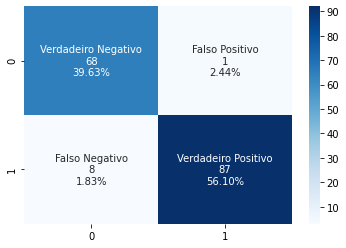

In [49]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_rf.flatten()/np.sum(mc_rf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_rf, annot=labels, fmt='', cmap='Blues')

In [50]:
# Exibição dos resultados
evaluator_rf = spark.createDataFrame(
    [(round(accuracy_rf,2), round(recall_rf,2), round(precision_rf,2), round(f1_rf,2),\
      int(fp_rf), int(fn_rf),\
      round(time_rf_train,2), round(time_rf_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Random Forest:")
evaluator_rf.show()

Resultados do modelo Random Forest:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   95.73| 95.73|   95.73|   95.73|             4|             3|             2.83|          0.05|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [51]:
result_rf.toPandas()

,label,features,rawPrediction,probability,prediction
0,0,"(29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[43.87686507803931, 6.123134921960683]","[0.8775373015607864, 0.12246269843921369]",0.0
1,0,"(30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[43.87686507803931, 6.123134921960683]","[0.8775373015607864, 0.12246269843921369]",0.0
2,0,"(34.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[22.570190158840273, 27.429809841159724]","[0.45140380317680545, 0.5485961968231945]",1.0
3,0,"(65.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[43.67972769912793, 6.320272300872065]","[0.8735945539825587, 0.12640544601744133]",0.0
4,0,"(44.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[22.406790729071474, 27.593209270928526]","[0.4481358145814295, 0.5518641854185705]",1.0
...,...,...,...,...,...
159,1,"[69.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0,...","[9.409802784500368, 40.590197215499636]","[0.18819605569000736, 0.8118039443099927]",1.0
160,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[0.6803451100115748, 49.31965488998843]","[0.013606902200231497, 0.9863930977997686]",1.0
161,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[0.6803451100115748, 49.31965488998843]","[0.013606902200231497, 0.9863930977997686]",1.0
162,1,"[70.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0,...","[5.419258373205741, 44.58074162679426]","[0.10838516746411482, 0.8916148325358851]",1.0


### Neural Network Perceptron (NNP)

In [52]:
# Treinamento do modelo de predição
start_time =  time.time()
layers = [16, 5, 5, 2]
trainer = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label',\
          maxIter=100, layers=layers, blockSize=128, seed=1234)
model_nnp = trainer.fit(train)
time_nnp_train = time.time() - start_time

In [53]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_nnp = model_nnp.transform(test)
time_nnp_pred = time.time() - start_time

In [54]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_nnp = evaluator.evaluate(result_nnp) * 100

In [55]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_nnp = evaluator.evaluate(result_nnp) * 100

In [56]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_nnp = evaluator.evaluate(result_nnp) * 100

In [57]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_nnp = evaluator.evaluate(result_nnp) * 100

In [58]:
# Matriz de confusão
y_true = result_nnp.select("label").toPandas()
y_pred = result_nnp.select("prediction").toPandas()
mc_nnp = confusion_matrix(y_true, y_pred)
tn_nnp, fp_nnp, fn_nnp, tp_nnp = confusion_matrix(y_true, y_pred).ravel()
print(mc_nnp)

[[59 10]
 [ 3 92]]


<AxesSubplot:>

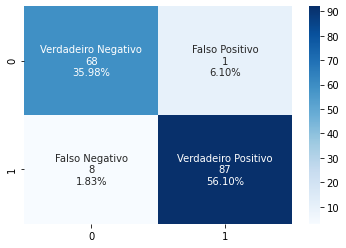

In [59]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_nnp.flatten()/np.sum(mc_nnp)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_nnp, annot=labels, fmt='', cmap='Blues')

In [60]:
# Exibição dos resultados
evaluator_nnp = spark.createDataFrame(
    [(round(accuracy_nnp,2), round(recall_nnp,2), round(precision_nnp,2), round(f1_nnp,2),\
      int(fp_nnp), int(fn_nnp),\
      round(time_nnp_train,2), round(time_nnp_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Neural Network Perceptron:")
evaluator_nnp.show()

Resultados do modelo Neural Network Perceptron:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   92.07| 92.07|   92.29|    92.0|            10|             3|             7.54|          0.05|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [61]:
result_nnp.toPandas()

,label,features,rawPrediction,probability,prediction
0,0,"(29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.0446294415037043, -1.4129273094846229]","[0.9694557017718708, 0.030544298228129093]",0.0
1,0,"(30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.04915133380501, -1.4183026086439343]","[0.9697474131558287, 0.030252586844171318]",0.0
2,0,"(34.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[-1.2828025306732789, 2.176462643103266]","[0.030493750086484465, 0.9695062499135155]",1.0
3,0,"(65.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.0855514096629832, -1.4617365223741818]","[0.9720037184932339, 0.027996281506766117]",0.0
4,0,"(44.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[-1.3760453058795148, 2.2721679932394228]","[0.025376856015892155, 0.9746231439841079]",1.0
...,...,...,...,...,...
159,1,"[69.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0,...","[-1.3776355551684762, 2.273795211793296]","[0.025297400202464224, 0.9747025997975358]",1.0
160,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[-1.3776387950593332, 2.273798526558089]","[0.025297238581927263, 0.9747027614180727]",1.0
161,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[-1.3776387950593332, 2.273798526558089]","[0.025297238581927263, 0.9747027614180727]",1.0
162,1,"[70.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0,...","[-1.3776301479879365, 2.273789679655912]","[0.025297669939459394, 0.9747023300605407]",1.0


### Naive Bayes (NB)

In [62]:
# Treinamento do modelo de predição
start_time =  time.time()
trainer = NaiveBayes(smoothing=1.0, modelType='multinomial')
model_nb = trainer.fit(train)
time_nb_train = time.time() - start_time

In [63]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_nb = model_nb.transform(test)
time_nb_pred = time.time() - start_time

In [64]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_nb = evaluator.evaluate(result_nb) * 100

In [65]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_nb = evaluator.evaluate(result_nb) * 100

In [66]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_nb = evaluator.evaluate(result_nb) * 100

In [67]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_nb = evaluator.evaluate(result_nb) * 100

In [68]:
# Matriz de confusão
y_true = result_nb.select("label").toPandas()
y_pred = result_nb.select("prediction").toPandas()
mc_nb = confusion_matrix(y_true, y_pred)
tn_nb, fp_nb, fn_nb, tp_nb = confusion_matrix(y_true, y_pred).ravel()
print(mc_nb)

[[57 12]
 [ 3 92]]


<AxesSubplot:>

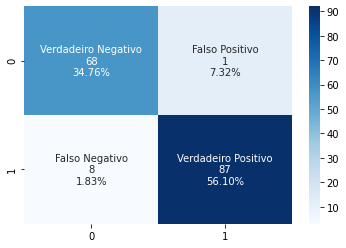

In [69]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_nb.flatten()/np.sum(mc_nb)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_nb, annot=labels, fmt='', cmap='Blues')

In [70]:
# Exibição dos resultados
evaluator_nb = spark.createDataFrame(
    [(round(accuracy_nb,2), round(recall_nb,2), round(precision_nb,2), round(f1_nb,2),\
      int(fp_nb), int(fn_nb),\
      round(time_nb_train,2), round(time_nb_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Naive Bayes:")
evaluator_nb.show()

Resultados do modelo Naive Bayes:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   90.85| 90.85|   91.21|   90.74|            12|             3|             0.79|          0.03|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [71]:
result_nb.toPandas()

,label,features,rawPrediction,probability,prediction
0,0,"(29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-3.340214085269986, -4.321113339016939]","[0.7272866114951847, 0.27271338850481525]",0.0
1,0,"(30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-3.4209893618719054, -4.454255247702751]","[0.7375485658379636, 0.2624514341620363]",0.0
2,0,"(34.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[-20.045341727400007, -19.403546314415777]","[0.34484079667842327, 0.6551592033215767]",1.0
3,0,"(65.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-25.876943569978657, -28.751857606670956]","[0.946592324466571, 0.05340767553342896]",0.0
4,0,"(44.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[-42.54283327828776, -41.1251134160444]","[0.1950192861392353, 0.8049807138607648]",1.0
...,...,...,...,...,...
159,1,"[69.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0,...","[-54.97126264149225, -52.66767550173077]","[0.09082631106737811, 0.9091736889326218]",1.0
160,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[-59.15118020824081, -52.74304432912251]","[0.001645382142309034, 0.998354617857691]",1.0
161,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[-59.15118020824081, -52.74304432912251]","[0.001645382142309034, 0.998354617857691]",1.0
162,1,"[70.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0,...","[-56.56732776590413, -53.331731698438645]","[0.03784793578301634, 0.9621520642169836]",1.0


### Logistic Regression (LR)

In [72]:
# Treinamento do modelo de predição
start_time =  time.time()
trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
model_lr = trainer.fit(train)
time_lr_train = time.time() - start_time

In [73]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_lr = model_lr.transform(test)
time_lr_pred = time.time() - start_time

In [74]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_lr = evaluator.evaluate(result_lr) * 100

In [75]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_lr = evaluator.evaluate(result_lr) * 100

In [76]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_lr = evaluator.evaluate(result_lr) * 100

In [77]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_lr = evaluator.evaluate(result_lr) * 100

In [78]:
# Matriz de confusão
y_true = result_lr.select("label").toPandas()
y_pred = result_lr.select("prediction").toPandas()
mc_lr = confusion_matrix(y_true, y_pred)
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_true, y_pred).ravel()
print(mc_lr)

[[57 12]
 [ 4 91]]


<AxesSubplot:>

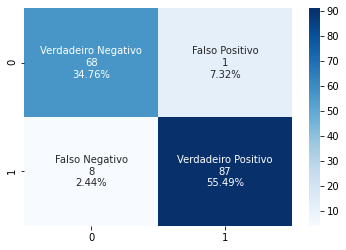

In [79]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_lr.flatten()/np.sum(mc_lr)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_lr, annot=labels, fmt='', cmap='Blues')

In [80]:
# Exibição dos resultados
evaluator_lr = spark.createDataFrame(
    [(round(accuracy_lr,2), round(recall_lr,2), round(precision_lr,2), round(f1_lr,2),\
      int(fp_lr), int(fn_lr),\
      round(time_lr_train,2), round(time_lr_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Logistic Regression:")
evaluator_lr.show()

Resultados do modelo Logistic Regression:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   90.24| 90.24|   90.49|   90.14|            12|             4|             1.35|          0.03|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [81]:
result_lr.toPandas()

,label,features,rawPrediction,probability,prediction
0,0,"(29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.038996755861848, -2.038996755861848]","[0.8848310717786301, 0.11516892822136991]",0.0
1,0,"(30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.101075566763122, -2.101075566763122]","[0.8910076742540237, 0.10899232574597628]",0.0
2,0,"(34.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[-1.595169082036774, 1.595169082036774]","[0.1686578856708921, 0.831342114329108]",1.0
3,0,"(65.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4.735441695347316, -4.735441695347316]","[0.9912978221603043, 0.008702177839695846]",0.0
4,0,"(44.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...","[-1.1266760509648144, 1.1266760509648144]","[0.2447750454556436, 0.7552249545443563]",1.0
...,...,...,...,...,...
159,1,"[69.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0,...","[-6.4153086037269835, 6.4153086037269835]","[0.0016336417051544569, 0.9983663582948455]",1.0
160,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[-9.85225291864559, 9.85225291864559]","[5.262572203096897e-05, 0.999947374277969]",1.0
161,1,"[69.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[-9.85225291864559, 9.85225291864559]","[5.262572203096897e-05, 0.999947374277969]",1.0
162,1,"[70.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0,...","[-6.063955157861827, 6.063955157861827]","[0.0023197922493726274, 0.9976802077506274]",1.0


## Suport Vector Machines (SVM)

In [82]:
# Treinamento do modelo de predição
start_time =  time.time()
trainer = LinearSVC(featuresCol='features', labelCol='label',\
                    maxIter=100, regParam=0.1)
model_svm = trainer.fit(train)
time_svm_train = time.time() - start_time

In [83]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_svm = model_svm.transform(test)
time_svm_pred = time.time() - start_time

In [84]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_svm = evaluator.evaluate(result_svm) * 100

In [85]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_svm = evaluator.evaluate(result_svm) * 100

In [86]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_svm = evaluator.evaluate(result_svm) * 100

In [87]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_svm = evaluator.evaluate(result_svm) * 100

In [88]:
# Matriz de confusão
y_true = result_svm.select("label").toPandas()
y_pred = result_svm.select("prediction").toPandas()
mc_svm = confusion_matrix(y_true, y_pred)
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_true, y_pred).ravel()
print(mc_svm)

[[63  6]
 [ 5 90]]


<AxesSubplot:>

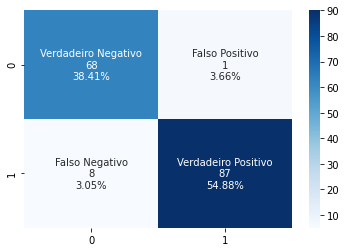

In [89]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_svm.flatten()/np.sum(mc_svm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_svm, annot=labels, fmt='', cmap='Blues')

In [ ]:
# Exibição dos resultados
evaluator_svm = spark.createDataFrame(
    [(round(accuracy_svm,2), round(recall_svm,2), round(precision_svm,2), round(f1_svm,2),\
      int(fp_svm), int(fn_svm),\
      round(time_svm_train,2), round(time_svm_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Suport Vector Machines:")
evaluator_svm.show()

Resultados do modelo Suport Vector Machines:


In [ ]:
result_svm.toPandas()

## Resultados

In [ ]:
models = ['Decision Tree','Random Forest','Neural Network Perceptron','Naive Bayes','Logistic Regression','Suport Vector Machines']

### Accuracy

In [ ]:
print('Ranking Accuracy %')

list = ((models[0],accuracy_dt),\
        (models[1],accuracy_rf),\
        (models[2],accuracy_nnp),\
        (models[3],accuracy_nb),\
        (models[4],accuracy_lr),\
        (models[5],accuracy_nb))
df_acuracia = spark.createDataFrame(list, ['Modelo', 'Acuracia'])
df_acuracia.sort(df_acuracia.Acuracia.desc()).toPandas()


### Recall

In [ ]:
print('Ranking')

list = ((models[0],recall_dt),\
        (models[1],recall_rf),\
        (models[2],recall_nnp),\
        (models[3],recall_nb),\
        (models[4],recall_lr),\
        (models[5],recall_svm))
df_recall = spark.createDataFrame(list, ['Modelo', 'Recall'])
df_recall.sort(df_recall.Recall.desc()).toPandas()

### Precision

In [ ]:
print('Ranking Precision %')

list = ((models[0],precision_dt),\
        (models[1],precision_rf),\
        (models[2],precision_nnp),\
        (models[3],precision_nb),\
        (models[4],precision_lr),\
        (models[5],precision_svm))
df_precision = spark.createDataFrame(list, ['Modelo', 'Precisao'])
df_precision.sort(df_precision.Precisao.desc()).toPandas()

### F1 score

In [ ]:
list = ((models[0],f1_dt),\
        (models[1],f1_rf),\
        (models[2],f1_nnp),\
        (models[3],f1_nb),\
        (models[4],f1_lr),\
        (models[5],f1_svm))
df_f1 = spark.createDataFrame(list, ['Modelo', 'F1'])
df_f1.sort(df_f1.F1.desc()).toPandas()

### Tempo de Treinamento

In [ ]:
list = ((models[0],time_dt_train),\
        (models[1],time_rf_train),\
        (models[2],time_nnp_train),\
        (models[3],time_nb_train),\
        (models[4],time_lr_train),\
        (models[5],time_svm_train))
df_time_train = spark.createDataFrame(list, ['Modelo', 'Tempo_Treinamento'])
df_time_train.sort(df_time_train.Tempo_Treinamento.asc()).toPandas()

### Tempo de Predição

In [ ]:
list = ((models[0],time_dt_pred),\
        (models[1],time_rf_pred),\
        (models[2],time_nnp_pred),\
        (models[3],time_nnp_pred),\
        (models[4],time_nnp_pred),\
        (models[5],time_nnp_pred))
df_time_pred = spark.createDataFrame(list, ['Modelo', 'Tempo_Predicao'])
df_time_pred.sort(df_time_pred.Tempo_Predicao.asc()).toPandas()

### Falso Positivo

In [ ]:
list = ((models[0],int(fp_dt)),\
        (models[1],int(fp_rf)),\
        (models[2],int(fp_nnp)),\
        (models[3],int(fp_nb)),\
        (models[4],int(fp_lr)),\
        (models[5],int(fp_svm)))
df_fp = spark.createDataFrame(list, ['Modelo', 'Falso_Positivo'])
df_fp.sort(df_fp.Falso_Positivo.asc()).toPandas()

### Falso Negativo

In [ ]:
list = ((models[0],int(fn_dt)),\
        (models[1],int(fn_rf)),\
        (models[2],int(fn_nnp)),\
        (models[3],int(fn_nb)),\
        (models[4],int(fn_lr)),\
        (models[5], int(fn_svm)))
df_fn = spark.createDataFrame(list, ['Modelo', 'Falso_Negativo'])
df_fn.sort(df_fn.Falso_Negativo.asc()).toPandas()

### Comparativo

In [ ]:
df = df_acuracia.join(df_fp, "Modelo")
df = df.join(df_fn, "Modelo")
df = df.join(df_time_train, "Modelo")
df = df.join(df_time_pred, "Modelo")
df.sort(df.Acuracia.desc()).toPandas()

## Exportação do modelo

In [ ]:
model_dt.save('model')

---

In [ ]:
spark.stop()